In [1]:
from IPython.display import Markdown, display_markdown, display, HTML

import pandas as pd
import warnings
from model_drift import settings
from model_drift.helpers import prepare_padchest, nested2series
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from model_drift.drift.numeric import KSDriftStat, BasicDriftStat
from model_drift.drift.categorical import ChiSqDriftStat
from model_drift.drift.collection import StatCollection

warnings.filterwarnings("ignore")

# Real Valued Number Drift Detection

In [2]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)

df = df.set_index('StudyDate', drop=False)

In [3]:
df.head()

,Unnamed: 0,ImageID,ImageDir,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,Projection,...,RelativeXRayExposure_DICOM,ReportID,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS,StudyDate
StudyDate,,,,,,,,,,,,,,,,,,,,,
2014-09-15,0,20536686640136348236148679891455886468_k6ga29.png,0,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930-01-01,F,POSTEROANTERIOR,PA,...,-1.42,4765777,sin hallazg patolog edad pacient .,Physician,['normal'],[],"[['normal'], ['normal']]",[],[],2014-09-15
2015-09-14,1,135803415504923515076821959678074435083_fzis7d...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929-01-01,M,LATERAL,L,...,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378'],2015-09-14
2015-09-14,2,135803415504923515076821959678074435083_fzis7b...,0,20150914,135803415504923515076821959678074435083,313572750430997347502932654319389875966,1929-01-01,M,POSTEROANTERIOR,PA,...,None,4991845,cambi pulmonar cronic sever . sign fibrosis b...,Physician,"['pulmonary fibrosis', 'chronic changes', 'kyp...","['loc basal', 'loc basal bilateral']","[['pulmonary fibrosis', 'loc basal bilateral']...",['C0034069' 'C0742362' 'C2115817' 'C3544344'],['C1282378'],2015-09-14
2015-07-17,3,113855343774216031107737439268243531979_3k951l...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925-01-01,F,POSTEROANTERIOR,PA,...,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151'],2015-07-17
2015-07-17,4,113855343774216031107737439268243531979_3k951n...,0,20150717,113855343774216031107737439268243531979,50783093527901818115346441867348318648,1925-01-01,F,LATERAL,L,...,None,4955977,. . siluet cardi mediastin dentr normal . cam...,Physician,['chronic changes'],"['loc cardiac', 'loc mediastinum', 'loc costop...","[['chronic changes'], ['chronic changes'], ['n...",['C0742362'],['C1522601' 'C0025066' 'C0230151'],2015-07-17


In [4]:
list(df)

['Unnamed: 0',
 'ImageID',
 'ImageDir',
 'StudyDate_DICOM',
 'StudyID',
 'PatientID',
 'PatientBirth',
 'PatientSex_DICOM',
 'ViewPosition_DICOM',
 'Projection',
 'MethodProjection',
 'Pediatric',
 'Modality_DICOM',
 'Manufacturer_DICOM',
 'PhotometricInterpretation_DICOM',
 'PixelRepresentation_DICOM',
 'PixelAspectRatio_DICOM',
 'SpatialResolution_DICOM',
 'BitsStored_DICOM',
 'WindowCenter_DICOM',
 'WindowWidth_DICOM',
 'Rows_DICOM',
 'Columns_DICOM',
 'XRayTubeCurrent_DICOM',
 'Exposure_DICOM',
 'ExposureInuAs_DICOM',
 'ExposureTime',
 'RelativeXRayExposure_DICOM',
 'ReportID',
 'Report',
 'MethodLabel',
 'Labels',
 'Localizations',
 'LabelsLocalizationsBySentence',
 'labelCUIS',
 'LocalizationsCUIS',
 'StudyDate']

In [5]:
# Example
df['age'] = (df["StudyDate"]-df['PatientBirth']) / np.timedelta64(1, 'Y')



In [6]:
test_split_date = "2014-01-01"
train_val_split_date = "2013-01-01"

df_trainval, df_test = df[df['StudyDate'] < test_split_date], df[df["StudyDate"] >= test_split_date]

df_val = df_trainval[df_trainval["StudyDate"] >= train_val_split_date]


In [7]:
day = "2014-05-05"
window = "30D"

day_dt = pd.to_datetime(day)
delta = pd.tseries.frequencies.to_offset(window)
sample = df_test.loc[str(day_dt-delta):str(day_dt)]
sample['StudyDate'].describe()

count                    2255
unique                     26
top       2014-05-05 00:00:00
freq                      219
first     2014-04-07 00:00:00
last      2014-05-05 00:00:00
Name: StudyDate, dtype: object

In [8]:
data = pd.concat([df_val.assign(src="ref"), sample.assign(src="sample")]).reset_index(drop=True)
data['terb'] = np.random.uniform(size=len(data))+ (data['src']=='sample')*1.3
data['dist'] = ''

In [9]:
ks_test = KSDriftStat(df_val['age'].values)
stats_test = BasicDriftStat(df_val['age'].values)


rv_test = StatCollection([ks_test, stats_test])
stats = rv_test(sample['age'].values)

display(nested2series(stats, name=day).to_frame().sort_index(axis=0))

2014-05-05
ks    critical_diff          5.092850e-02
      critical_value         2.705099e-02
      distance               7.797949e-02
      pval                   2.839598e-11
stats mean           ref     6.039504e+01
                     sample  6.290306e+01
      median         ref     6.380418e+01
                     sample  6.628473e+01
      std            ref     1.897286e+01
                     sample  1.795997e+01

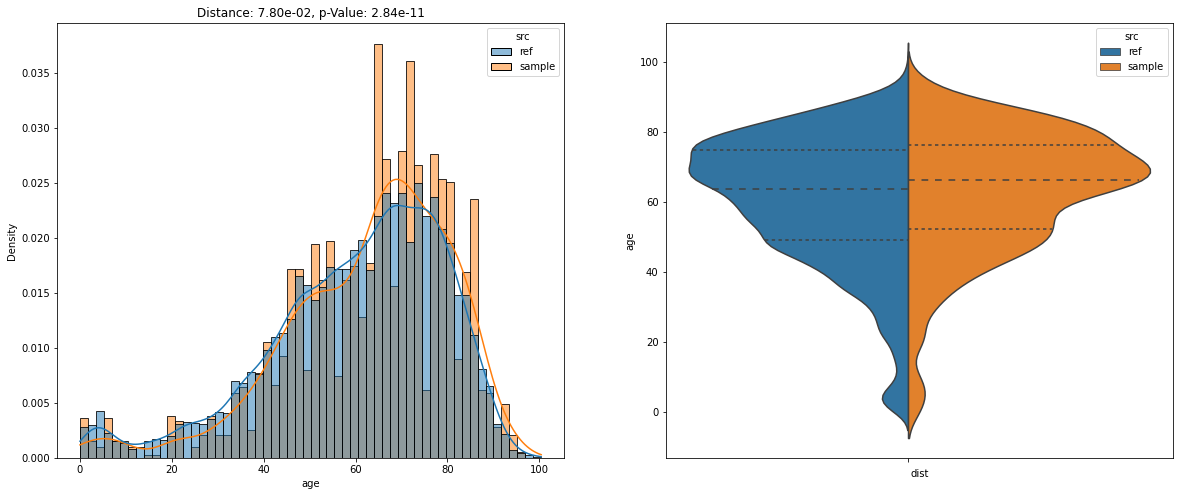

In [10]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10*2, 8))

sns.histplot(data, x='age', stat='density', kde=True, hue='src', common_norm=False, ax=ax1)
ax1.set_title(f"Distance: {stats['ks']['distance']:.2e}, p-Value: {stats['ks']['pval']:.2e}")
sns.violinplot(data=data, y='age', hue='src', x='dist', ax=ax2, inner="quartile", split=True)



# sns.stripplot(data=data, y='age', x='src', dodge=True, ax=ax2, jitter=0.25, alpha=.3)

# sns.pointplot(data=data, y='age', x='src', join=False, ci=0, capsize=.7, scale=0, ax=ax2)
# sns.swarmplot(data=data, y='age', x='src', color=".25", ax=ax2)

# means = data.groupby("src")['age'].mean()
# sns.scatterplot(data=data, x='terb', y='age', hue='src', ax=ax2, alpha=.5)
# sns.lineplot(x=[0, 1], y=[means['ref'], means['ref']], linewidth=3, ax=ax2)
# sns.lineplot(x=[1.3, 1+1.3], y=[means['sample'], means['sample']], linewidth=3, ax=ax2)




In [11]:
col = "Projection"
chi2_test = ChiSqDriftStat(df_val[col].values)
stats = chi2_test(sample[col].values)
stats

{'distance': 6.751263401336422,
 'pval': 0.2398060810665436,
 'dof': 5,
 'critical_value': 9.236356899781123,
 'critical_diff': -2.4850934984447015}

,2014-05-05
distance,6.751263
pval,0.239806
dof,5.000000
critical_value,9.236357
critical_diff,-2.485093


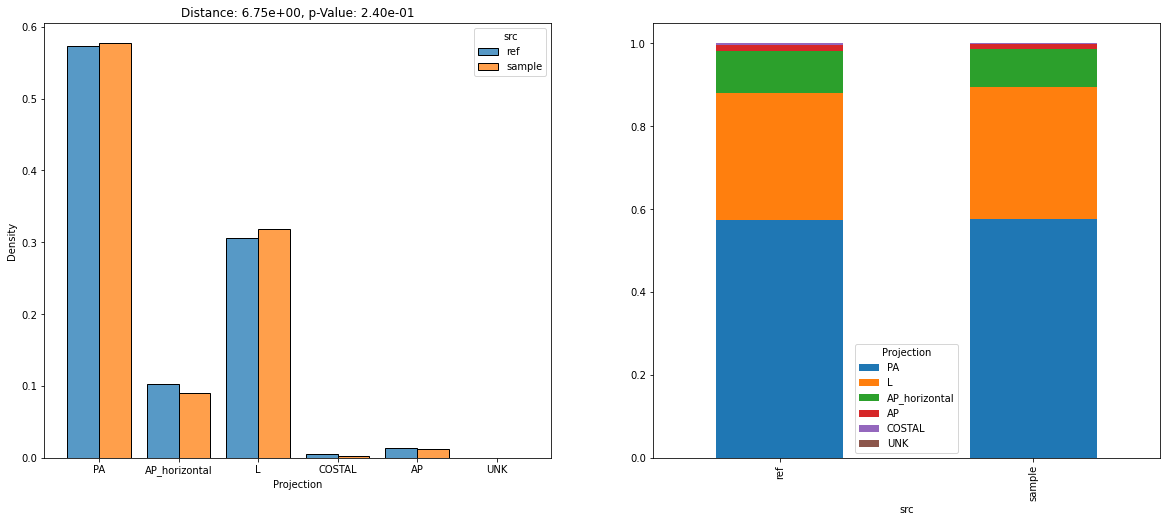

In [12]:
display(nested2series(stats, name=day).to_frame())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10*2, 8))
ax1.set_title(f"Distance: {stats['distance']:.2e}, p-Value: {stats['pval']:.2e}")
sns.histplot(data=data, x=col, hue="src", multiple="dodge", shrink=.8, ax=ax1, stat='density', common_norm=False)
data2 = data.groupby('src')[col].value_counts(normalize=True).unstack().T.sort_values('ref', ascending=False).T
data2.plot(kind='bar', stacked=True, ax=ax2)

In [13]:
from model_drift.drift.window_calculator import DriftWindowCalculator

dwc = DriftWindowCalculator(df_val)

dwc.add_drift_stat('age', KSDriftStat)
dwc.add_drift_stat('RelativeXRayExposure_DICOM', KSDriftStat)
dwc.add_drift_stat('WindowCenter_DICOM', KSDriftStat)
dwc.add_drift_stat('WindowWidth_DICOM', KSDriftStat)

dwc.add_drift_stat('Projection', ChiSqDriftStat)
dwc.add_drift_stat('PatientSex_DICOM', ChiSqDriftStat)
dwc.add_drift_stat('Modality_DICOM', ChiSqDriftStat)

dwc.prepare()

dwc._metric_collections
results = dwc.predict(sample)

In [14]:
output = dwc.rolling_window_predict(df_test, stride='D')
output

100%|██████████| 1417/1417 [02:03<00:00, 11.47it/s]


Modality_DICOM                                         \
                     chi2                                          
            critical_diff critical_value      distance  dof pval   
2014-01-01            NaN            NaN      0.000000  0.0  1.0   
2014-01-02            NaN            NaN      0.000000  0.0  1.0   
2014-01-03            NaN            NaN      0.000000  0.0  1.0   
2014-01-04            NaN            NaN      0.000000  0.0  1.0   
2014-01-05            NaN            NaN      0.000000  0.0  1.0   
...                   ...            ...           ...  ...  ...   
2017-11-13   16887.583783       2.705543  16890.289326  1.0  0.0   
2017-11-14   17026.223308       2.705543  17028.928851  1.0  0.0   
2017-11-15   17073.011322       2.705543  17075.716866  1.0  0.0   
2017-11-16   17446.791812       2.705543  17449.497355  1.0  0.0   
2017-11-17   17512.361541       2.705543  17515.067085  1.0  0.0   

           PatientSex_DICOM                                          ...  \
                       chi2                                          ...   
              critical_diff critical_value  distance  dof      pval  ...   
2014-01-01        -4.236511        4.60517  0.368660  2.0  0.831661  ...   
2014-01-02        -4.600601        4.60517  0.004569  2.0  0.997718  ...   
2014-01-03        -4.022248        4.60517  0.582922  2.0  0.747171  ...   
2014-01-04        -4.022248        4.60517  0.582922  2.0  0.747171  ...   
2014-01-05        -4.022248        4.60517  0.582922  2.0  0.747171  ...   
...                     ...            ...       ...  ...       ...  ...   
2017-11-13         5.084967        4.60517  9.690137  2.0  0.007867  ...   
2017-11-14         4.884923        4.60517  9.490093  2.0  0.008695  ...   
2017-11-15         3.432346        4.60517  8.037517  2.0  0.017975  ...   
2017-11-16         4.182499        4.60517  8.787669  2.0  0.012353  ...   
2017-11-17         3.761306        4.60517  8.366476  2.0  0.015249  ...   

           WindowCenter_DICOM WindowWidth_DICOM                           \
                           ks                ks                            
                         pval     critical_diff critical_value  distance   
2014-01-01           0.107469         -0.019317       0.706637  0.687320   
2014-01-02           0.565718          0.053807       0.353390  0.407197   
2014-01-03           0.334055         -0.035279       0.280890  0.245612   
2014-01-04           0.334055         -0.035279       0.280890  0.245612   
2014-01-05           0.334055         -0.035279       0.280890  0.245612   
...                       ...               ...            ...       ...   
2017-11-13           0.000000          0.648238       0.039082  0.687320   
2017-11-14           0.000000          0.648807       0.038513  0.687320   
2017-11-15           0.000000          0.649531       0.037788  0.687320   
2017-11-16           0.000000          0.649300       0.038019  0.687320   
2017-11-17           0.000000          0.648979       0.038340  0.687320   

                               age                                      count  
                                ks                                             
                pval critical_diff critical_value  distance      pval          
2014-01-01  0.061141     -0.173854       0.706637  0.532783  0.261279     3.0  
2014-01-02  0.026004      0.023774       0.353390  0.377165  0.048320    12.0  
2014-01-03  0.170414      0.043643       0.280890  0.324533  0.027848    19.0  
2014-01-04  0.170414      0.043643       0.280890  0.324533  0.027848    19.0  
2014-01-05  0.170414      0.043643       0.280890  0.324533  0.027848    19.0  
...              ...           ...            ...       ...       ...     ...  
2017-11-13  0.000000      0.032866       0.039082  0.071948  0.000073  1026.0  
2017-11-14  0.000000      0.032426       0.038513  0.070939  0.000073  1058.0  
2017-11-15  0.000000      0.033562       0.03778

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots (rows=2, cols=1)
graph_view = output.swaplevel(0,-1, axis=1)
g = graph_view['distance']['ks']
for c in list(g.columns.to_flat_index()):
    y = g[c].rolling(3).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, 
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=1, col=1)


g = graph_view['distance']['chi2']
for c in list(g.columns.to_flat_index()):
    y = g[c].rolling(3).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, 
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=2, col=1)

    

fig.update_layout(title = "Input Data Drift, Statisical Distance")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)
fig.show()

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots (rows=2, cols=1)
graph_view = output.swaplevel(0,-1, axis=1)
g = graph_view['pval']['ks']
for c in list(g.columns.to_flat_index()):
    y = g[c].rolling(3).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, 
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=1, col=1)


g = graph_view['pval']['chi2']
for c in list(g.columns.to_flat_index()):
    y = g[c].rolling(3).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, 
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=2, col=1)

    

fig.update_layout(title = "Input Data Drift, P Values")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)
fig.show()

2015-12-23    2016-02-15
Modality_DICOM chi2 distance               0.0  14204.568447
                    pval                   1.0      0.000000
                    dof                    0.0      1.000000
                    critical_value         NaN      2.705543
                    critical_diff          NaN  14201.862904
count                                    858.0   1203.000000

In [24]:
data[cols[0]]

0        -0.73
1        -0.91
2          509
3         0.78
4        -1.05
         ...  
24339      388
24340      445
24341      146
24342      472
24343      367
Name: RelativeXRayExposure_DICOM, Length: 24344, dtype: object

2014-11-30  2015-01-08
WindowWidth_DICOM ks distance        1.386021e-01    0.684702
                     pval            1.392474e-22    0.000000
                     critical_value  3.368016e-02    0.045034
                     critical_diff   1.049220e-01    0.639668
count                                1.404000e+03  764.000000

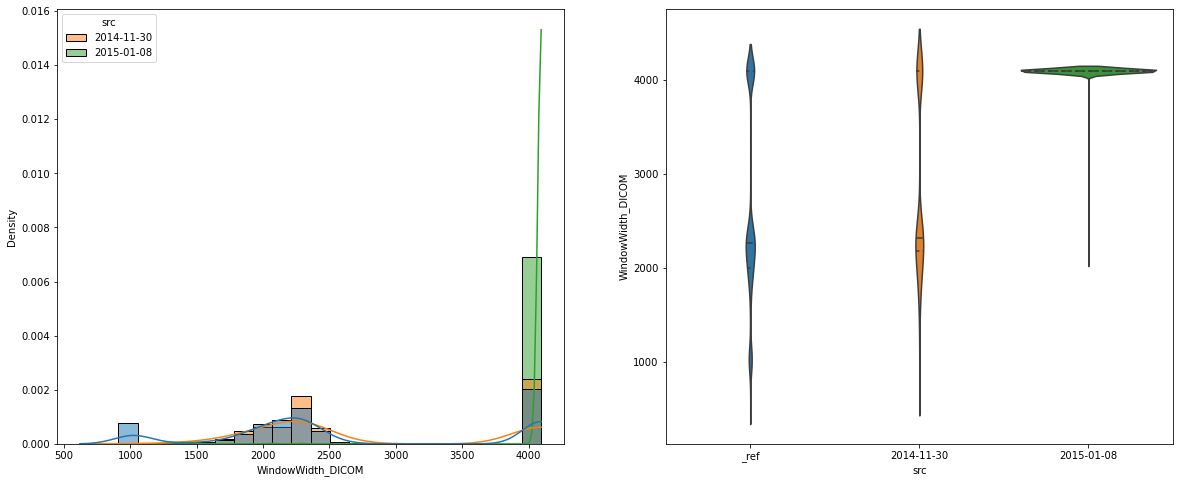

In [31]:
compare = ["2014-11-30", "2015-01-08"]

cols=["WindowWidth_DICOM"]
stats, data = dwc.compare_dates(df_test, compare, cols=cols)
for c in cols:
    data[c] = pd.to_numeric(data[c], errors='coerce')
display(stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10*2, 8))

sns.histplot(data, x=cols[0], stat='density', kde=True, hue='src', common_norm=False, ax=ax1)
# ax1.set_title(f"Distance: {stats['ks']['distance']:.2e}, p-Value: {stats['ks']['pval']:.2e}")
sns.violinplot(data=data, y=cols[0], x='src', ax=ax2, inner="quartile", split=True)

2015-12-23    2016-02-15
Modality_DICOM chi2 distance               0.0  14204.568447
                    pval                   1.0      0.000000
                    dof                    0.0      1.000000
                    critical_value         NaN      2.705543
                    critical_diff          NaN  14201.862904
count                                    858.0   1203.000000

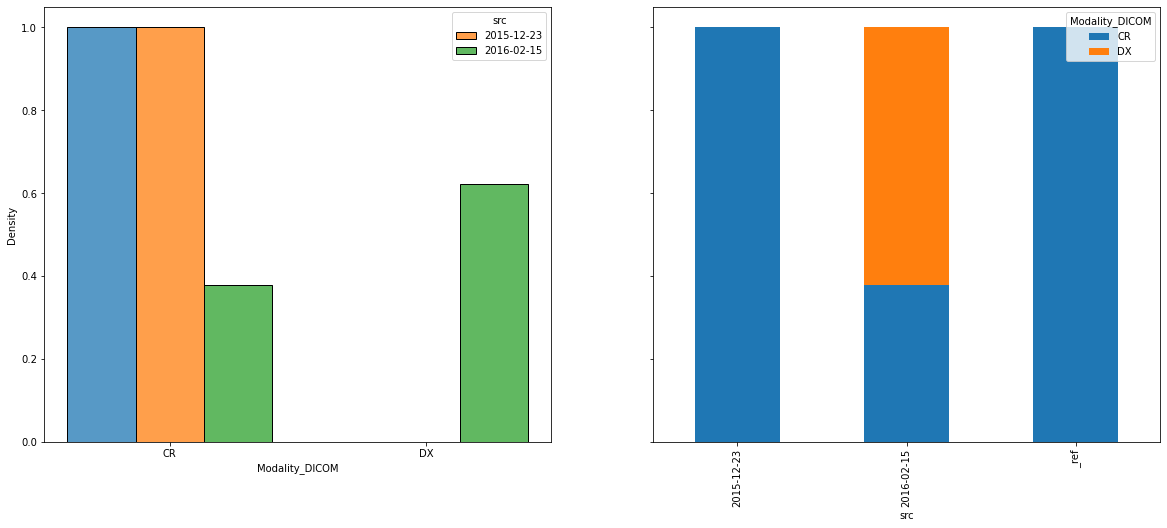

In [19]:
compare = ["2015-12-23", "2016-02-15"]

cols=["Modality_DICOM"]
stats, data = dwc.compare_dates(df_test, compare, cols=cols)
display(stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10*2, 8), sharey=True)
col="Modality_DICOM"
sns.histplot(data=data, x=col, hue="src", multiple="dodge", shrink=.8, ax=ax1, stat='density', common_norm=False)
data2 = data.groupby('src')[col].value_counts(normalize=True).unstack().T.sort_values('_ref', ascending=False).T
data2.plot(kind='bar', stacked=True, ax=ax2)

In [ ]:
FLOAT = "f"
CAT = 'c'

cols = {
'age': FLOAT,
'image_size': FLOAT,
'Projection': CAT,
"PatientSex_DICOM": CAT,
# "ViewPosition_DICOM": CAT,
"Modality_DICOM": CAT,
"Manufacturer_DICOM": CAT,
# "PhotometricInterpretation_DICOM": CAT,
# "PixelRepresentation_DICOM": CAT,
# "PixelAspectRatio_DICOM": CAT,
# "SpatialResolution_DICOM": CAT,
# "BitsStored_DICOM": CAT,
"WindowCenter_DICOM": FLOAT,
"WindowWidth_DICOM": FLOAT,
"Rows_DICOM": FLOAT,
"Columns_DICOM": FLOAT,
"XRayTubeCurrent_DICOM": CAT,
# "Exposure_DICOM": CAT,
# "ExposureInuAs_DICOM": FLOAT,
# "RelativeXRayExposure_DICOM": FLOAT,
}